# AD, QLattice, Ubuntu, 25-11-21

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [2]:
import numpy as np
import pandas as pd
import feyn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import modsum, model_features_chart, crossvalidation_as_framework

feyn._qlattice._USE_V2_API=True

In [3]:
feyn.__version__

'2.1.2'

In [4]:
# Load the data
data = pd.read_csv("../data/ad_omics.csv")

In [5]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

In [6]:
target = "_clinical AD diagnosis"

## In depth modelling

In [34]:
projectname = 'ad_ms_proteomics_'
pathname = '../figures/'

### Get the test data

In [8]:
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [9]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 42
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [10]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

## Model summary

In [11]:
modsum(models_single, train_val, test)

,Model,AUC Train,AUC Test,BIC,NumFeatures,Loss
0,0,0.98,0.92,46.11,3,0.168468
1,1,0.98,0.93,49.11,3,0.182253
2,2,0.97,0.94,49.28,3,0.183027
3,3,0.97,0.93,49.45,3,0.162273
4,4,0.97,0.93,51.42,3,0.192819
5,5,0.98,0.95,52.27,3,0.196747
6,6,0.97,0.94,54.08,3,0.205037
7,7,0.97,0.94,54.86,3,0.208604
8,8,0.97,0.94,54.95,2,0.230524
9,9,0.97,0.91,57.0,3,0.218450


In [30]:
for model in models_single:
    print(model.sympify(    
        symbolic_lr=False,
        symbolic_cat=True,
        include_weights=False))

logreg(LILRA2 + MAPT + age at CSF collection)
logreg(IGKV2D-29 + LILRA2 + MAPT)
logreg(FAM174A + IGLV4-69 + MAPT)
logreg(MAPT*(AJAP1 + SERPINE2.1))
logreg(ENOPH1 + GPC1 + MAPT)
logreg(GPC1 + MAPT + age at CSF collection)
logreg(ENDOD1 + MAPT + PPIA)
logreg(GPC1 + MAPT + SERPINE2.1)
logreg(IGLV4-69 + MAPT)
logreg(MAPT + NXPH3 + SPINT2)


## Best model from autorun (BIC criterion)

In [31]:
best_model = models_single[0]

In [35]:
best_model.plot(train_val,test, filename=pathname+projectname+'bestmodel_summary'+'.html')

'/Users/miqueltrianaiglesias/repos/qlattice-clinical-omics-paper/figures/ad_ms_proteomics_bestmodel_summary.html'

# Plot feature conservation across models with dirac

In [13]:
model_features_chart(train_val, models_single, metric="roc_auc_score")

,roc_auc_score,MAPT,GPC1,LILRA2,SERPINE2.1,IGLV4-69,_age at CSF collection,FAM174A,ENOPH1,NXPH3,SPINT2,ENDOD1,PPIA,AJAP1,IGKV2D-29
Model#,,,,,,,,,,,,,,,
0,0.982051,True,False,True,False,False,True,False,False,False,False,False,False,False,False
1,0.976190,True,False,True,False,False,False,False,False,False,False,False,False,False,True
2,0.974359,True,False,False,False,True,False,True,False,False,False,False,False,False,False
3,0.972527,True,False,False,True,False,False,False,False,False,False,False,False,True,False
4,0.974725,True,True,False,False,False,False,False,True,False,False,False,False,False,False
5,0.980586,True,True,False,False,False,True,False,False,False,False,False,False,False,False
6,0.973260,True,False,False,False,False,False,False,False,False,False,True,True,False,False
7,0.969963,True,True,False,True,False,False,False,False,False,False,False,False,False,False
8,0.970330,True,False,False,False,True,False,False,False,False,False,False,False,False,False


In [14]:
#excello = model_features_chart(test, models_single, metric="roc_auc_score")

In [15]:
#excello.to_excel('AD_QLAttice_Ubuntu_features_chart_autorun_best_251121.xlsx')

# Exploring model 0 further

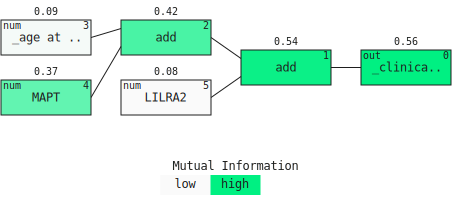

In [41]:
models_single[0].plot_signal(train_val,corr_func='mutual_information',filename=pathname+projectname+'bestmodel_signal_MI'+'.svg')

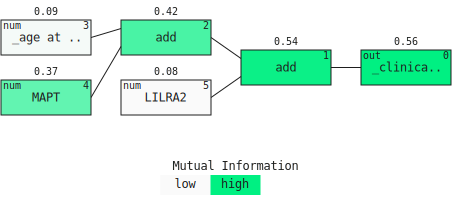

In [42]:
models_single[0].plot_signal(train_val,corr_func='mutual_information')

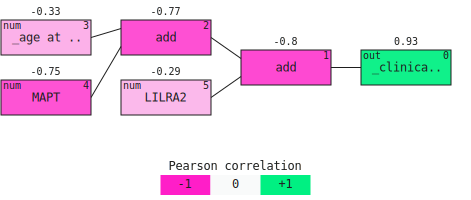

In [43]:
models_single[0].plot_signal(train_val, corr_func='pearson',filename=pathname+projectname+'bestmodel_signal_PEARSON'+'.svg')

In [22]:
sympy_model = models_single[0].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(98000000000000.0*exp(0.000673*LILRA2 - 0.00086*MAPT - 0.263*age at CSF collection) + 1)

In [37]:
models_single[0].inputs[-1]

'_age at CSF collection'

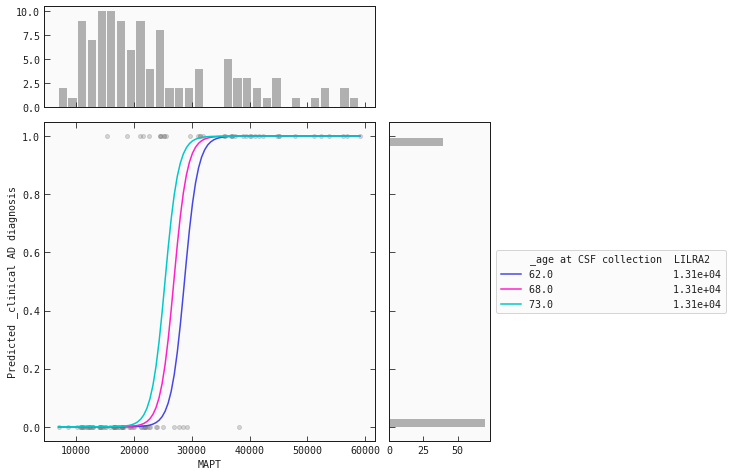

In [44]:
show_quantiles = '_age at CSF collection'
fixed = {}
fixed[show_quantiles] = [
    train_val[show_quantiles].quantile(q=0.25),
    train_val[show_quantiles].quantile(q=0.5),
    train_val[show_quantiles].quantile(q=0.75)
]

best_model.plot_response_1d(train_val, by = 'MAPT', input_constraints=fixed, filename=pathname+projectname+'bestmodel_response1d_age'+'.svg')

In [ ]:
best_model.plot_response_2d

# Cross-validation as a framework

In [24]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

In [46]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean()

(0.9415526506899056, 0.8666666666666666)

In [47]:
# average performance of first model
results.groupby("model_structure").first().roc_auc_val.mean(), results.groupby("model_structure").first().accuracy_val.mean()

(0.9365674170902929, 0.8623750734861847)

# Exploring model 5 further

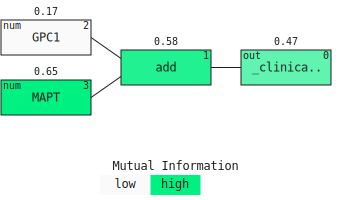

In [29]:
models_single[5].plot_signal(test,corr_func='mutual_information',filename=pathname+projectname+'bestmodelCV_signal_MI'+'.svg')

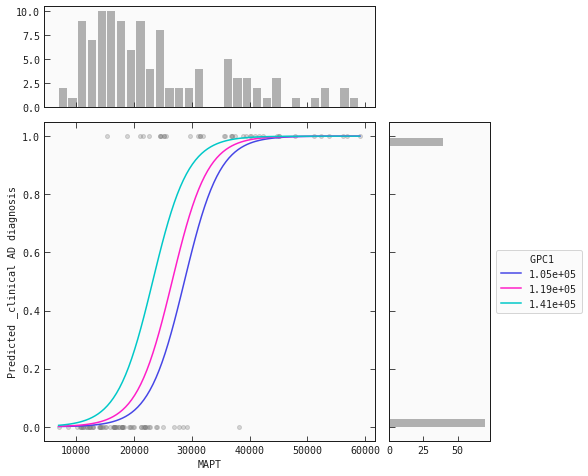

In [30]:
show_quantiles = 'GPC1'
fixed = {}
fixed[show_quantiles] = [
    train_val[show_quantiles].quantile(q=0.25),
    train_val[show_quantiles].quantile(q=0.5),
    train_val[show_quantiles].quantile(q=0.75)
]

models_single[5].plot_response_1d(train_val, by = "MAPT", input_constraints=fixed)